# Introduction to convolutional neural networks

### Author: [John F. Wu](https://jwuphysics.github.io/)

Presented as a tutorial during week 1 of the KITP program, [*Building a Physical Understanding of Galaxy Evolution with Data-driven Astronomy*](https://datadrivengalaxyevolution.github.io/) ([`galevo23`](https://www.kitp.ucsb.edu/activities/galevo23)). See other tutorials [here](https://github.com/DataDrivenGalaxyEvolution/galevo23-tutorials/tree/main/).


# Before getting started

[![Open this notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DataDrivenGalaxyEvolution/galevo23-tutorials/blob/main/week-1/Introduction%20to%20convolutional%20neural%20networks.ipynb)

- **Open this notebook in Colab.** Click [here](https://colab.research.google.com/github/DataDrivenGalaxyEvolution/galevo23-tutorials/) or click the above "badge" to open this notebook in Google Colab. This will expedite the setup process and allow you to train a model using a GPU (if available).

- **Use a GPU runtime.** This will make training neural networks much faster (but it will restart your runtime). You can do this by clicking on:
> Runtime > Change runtime type > Hardware accelerator - *select GPU and save*

- **Install some packages.** We will use `fastai` which is built on top `pytorch`, a popular deep learning framework. Unfortunately, these libraries have other dependencies (like CUDA, the language that the GPU speaks) and can take a while to install, but most of them should already be available on Colab.

- **Download image files.** Using convolutional neural networks, we can learn directly from individual pixels in multi-channel images. We will be using Sloan Digital Sky Survey $gri$-band image cutouts in the JPG format (see e.g. [SDSS SkyServer](http://skyserver.sdss.org/dr16/en/help/docs/api.aspx#imgcutout) or [DESI Legacy Imaging Surveys](https://www.legacysurvey.org/viewer/urls)).

- **Download value-added catalogs.** We will be predicting the gas-phase metallicity $Z$ for each galaxy. These metallicities are estimated from a model based on optical-wavelength strong lines ([Tremonti et al. 2004](https://ui.adsabs.harvard.edu/abs/2004ApJ...613..898T/abstract)).

In [ ]:
# fastai is a high-level deep learning library built on Pytorch
!pip install -q fastai --upgrade

# this also implicitly imports numpy, pandas, etc
from fastai.basics import *
from fastai.vision.all import *

In [ ]:
# download catalog of ~14000 galaxies
!wget -q -nc -O galaxies.csv https://www.dropbox.com/s/e5rfeg71ub8ab0k/galaxies.csv?dl=0

# download corresponding image cutouts
!wget -q -nc -O images.tar.gz https://www.dropbox.com/s/ru3cgknmidn0re9/images.tar.gz?dl=0
!tar xzf images.tar.gz

Our directory structure should look something like this:

```
.
├── galaxies.csv
├── images
│   ├── 1237648672922534053.jpg
│   ├── 1237648673459667002.jpg
│   └── [...]
└── [...]
```

In [ ]:
# you can check your GPU using this command:
!nvidia-smi

Thu Jan 12 16:18:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

If you see a message like 
> NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

then make sure you change your Runtime/Hardware accelerator to GPU.

# Can we predict a galaxy's gas-phase metallicity using three-color images?

[Acquaviva (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.456.1618A/abstract) found that $ugriz$ magnitudes and colors, plus stellar mass and photometric redshifts,supplied enough information to predict $Z$ to within a root mean squared error (RMSE) of $\sim 0.08$. But this requires another model to estimate stellar masses, photometric redshifts, and even to extract the magnitudes! Can we estimate metallicity purely using images? 

The answer turns out to be yes! [Wu & Boada (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484.4683W/abstract) also achieved RMSE$\ < 0.09$ scatter in predicting metallicity purely using $gri$-band imaging! 

Okay cool, let's go ahead and do it!

## But first, we want to take a look at our data.

Note that I've already selected a clean and small subsample from the entire SDSS Main Galaxy Survey, which is spectroscopically complete for galaxies in the SDSS footprint with $r < 17.78$ (modulo fiber collisions).

However my sub-selection process will *bias* the sample a bit, so our results today won't be representative of the full galaxy population (and will differ from the Wu & Boada 2019 results).

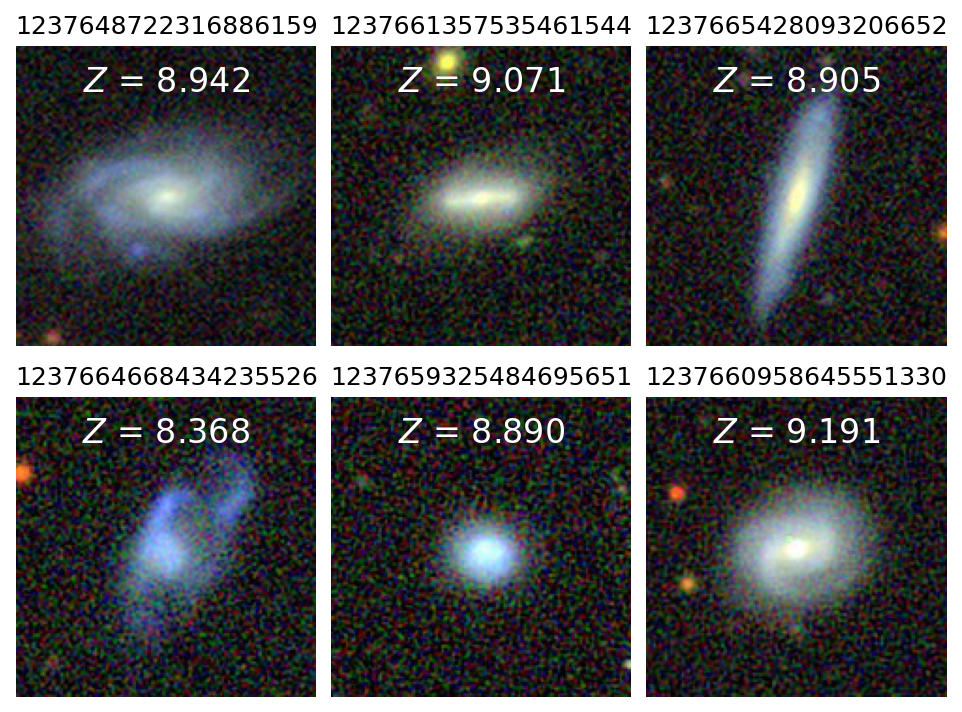

In [ ]:
df = pd.read_csv('galaxies.csv', dtype={'objID': str})
n_galaxies = len(df)

# set a random state
rng = np.random.RandomState(256)

# view six random galaxies and display their metallicities
fig, axes = plt.subplots(2, 3, figsize=(8, 6), dpi=150)
for i, ax in zip(rng.choice(range(n_galaxies), size=6, replace=False), axes.flat):

    objID = df.objID.iloc[i]
    PILImage.create(f'images/{objID}.jpg').show(ax=ax, title=objID)

    Z_gas = df.oh_p50.iloc[i]
    ax.text(0.5, 0.85, f'$Z$ = {Z_gas:.3f}', ha='center', transform=ax.transAxes, size=16, color='white')

fig.subplots_adjust(wspace=0.05, hspace=0.07)

## Look at the value-added catalog, including metallicity

Note that metallicity is defined $Z = 12 + \log({\rm O/H})$, and so the `oh_p50` is the column name for the 50th percentile estimate of the model-based metallicity. There are also a few other columns: Right Ascension (`ra`), Declination (`dec`), redshift (`z`), logarithmic stellar mass in solar masses (`lgm_tot_p50`), and star formation rate (`sfr_tot_p50`).

In [ ]:
df.sample(5, random_state=rng)

,objID,ra,dec,z,lgm_tot_p50,sfr_tot_p50,oh_p50
4826,1237665331467911252,198.465099,32.742969,0.044375,9.494723,0.076548,8.807961
7556,1237667551417466980,161.199089,23.866658,0.043490,9.986404,0.086080,8.957932
5639,1237659154223202513,255.765901,25.529686,0.031658,9.429852,-0.192042,8.672167
6442,1237660958104354844,116.683948,20.801785,0.035029,8.899995,-1.340389,8.724084
9736,1237651250974621865,237.067242,52.688118,0.042033,9.479498,-0.132161,8.743793


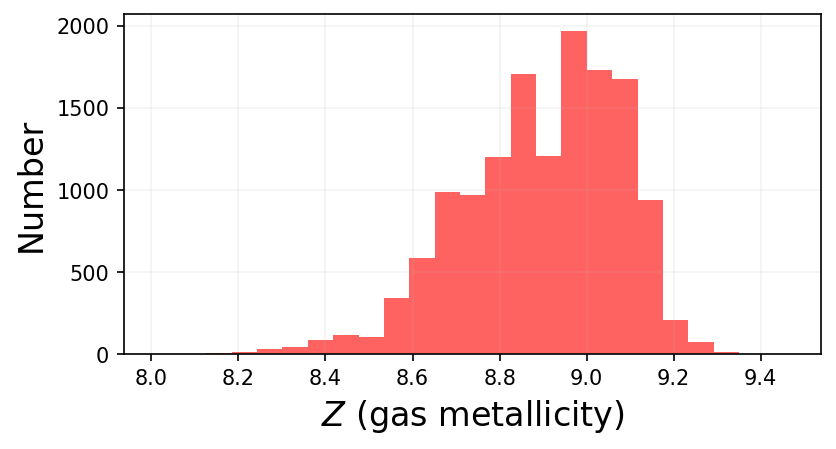

In [ ]:
plt.figure(figsize=(6, 3), dpi=150)
plt.hist(df.oh_p50, bins=25, color='#ff6361')
plt.xlabel('$Z$ (gas metallicity)', fontsize=16)
plt.ylabel('Number', fontsize=16)
plt.grid(alpha=0.15);

# Training a neural network with fastai

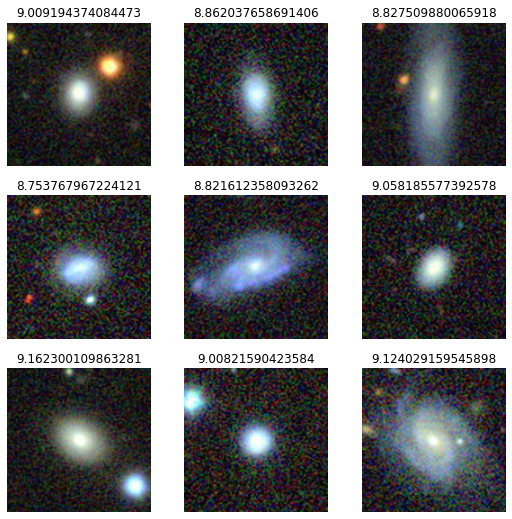

In [ ]:
# fastai "data blocks" determine how data can be fed into a model
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('objID', pref='images/', suff='.jpg'),
    get_y=ColReader('oh_p50'),
    splitter=RandomSplitter(0.2, seed=256),
    item_tfms=[Resize(160), CropPad(144)],
    batch_tfms=aug_transforms(do_flip=True, flip_vert=True, max_rotate=0, max_zoom=1.0, max_warp=0, p_lighting=0) + [Normalize()]
)

# "data loaders" actually load the data 
dls = ImageDataLoaders.from_dblock(dblock, df, bs=64)
dls.show_batch()

In [ ]:
# root mean squared error is our loss function
def RMSE(p, y): return torch.sqrt(MSELossFlat()(p, y))

# this is a reasonably deep CNN model with some bells and whistles
cnn_model = xresnet18(n_out=1, sa=True, act_cls=Mish)

# a "learner" evaluates and updates the model 
learn = Learner(
    dls,
    cnn_model,
    loss_func=RMSE,
    opt_func=Adam,
).to_fp16()

In [ ]:
# train in under ten minutes on NVidia T4 
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,0.617357,0.489637,00:49
1,0.200507,0.152080,00:41
2,0.202359,0.452525,00:41
3,0.166939,0.112493,00:40
4,0.134487,0.109079,00:42
5,0.120800,0.098092,00:41


Note: your training results may vary, but hopefully not by too much! 

Text(0, 0.5, 'RMSE Loss')

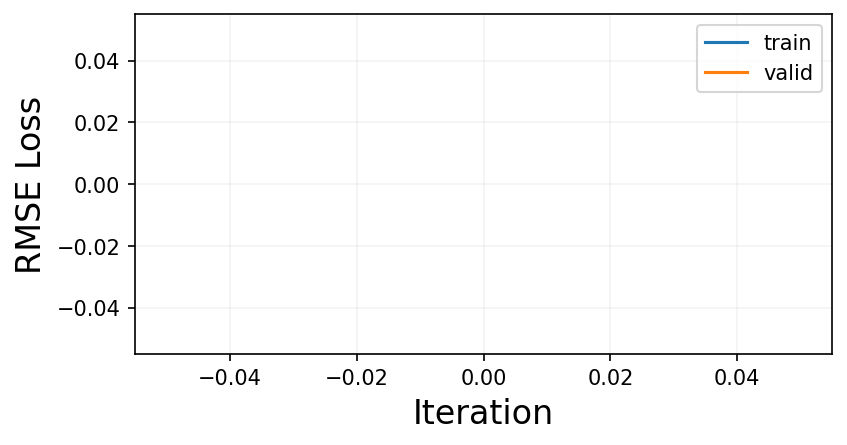

In [ ]:
fig = plt.figure(figsize=(6, 3), dpi=150)

learn.recorder.plot_loss(skip_start=200)

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('RMSE Loss', fontsize=16)
plt.ylim(0.08, 0.3)
plt.grid(alpha=0.15);

# Making predictions and comparing against ground-truth

In [ ]:
Z_pred, Z_true = learn.get_preds()

Text(0, 0.5, 'Predicted metallicity')

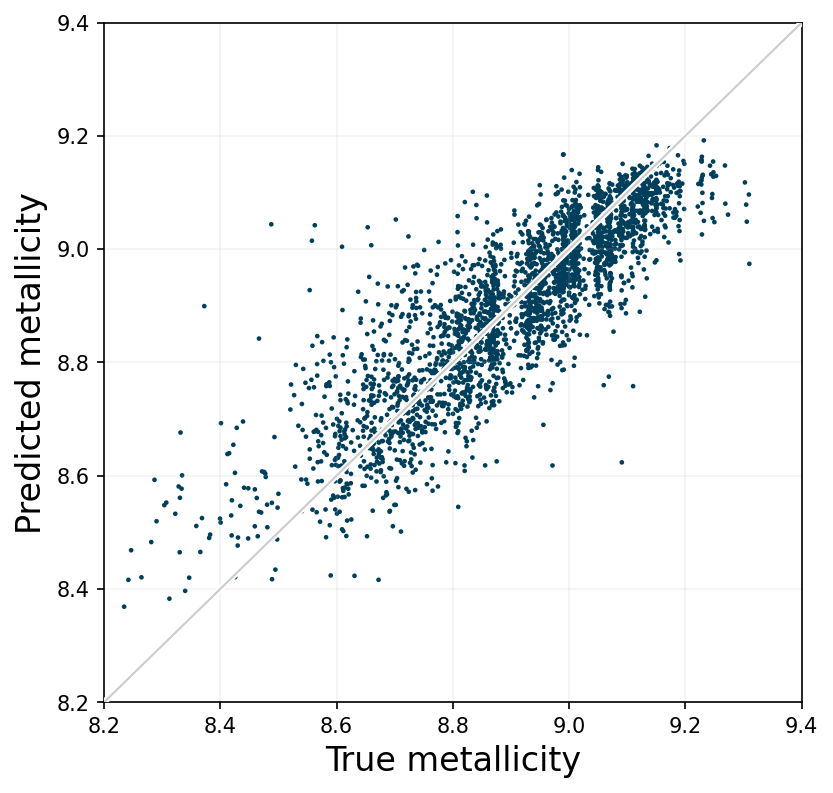

In [ ]:
plt.figure(figsize=(6, 6), dpi=150)

plt.scatter(
    Z_true.detach().cpu().unsqueeze(0), 
    Z_pred.detach().cpu(),
    c='#003f5c',
    edgecolor='none',
    s=5
)

plt.plot([8, 9.5], [8, 9.5], c='w', lw=3, alpha=1, zorder=8)
plt.plot([8, 9.5], [8, 9.5], c='0.8', lw=1, alpha=1, zorder=9)

plt.grid(alpha=0.15)
plt.xlim(8.2, 9.4)
plt.ylim(8.2, 9.4)
plt.xlabel('True metallicity', fontsize=16)
plt.ylabel('Predicted metallicity', fontsize=16)

# Understanding convolutions

A picture tells a thousand words, and an animation tells... a lot of pictures?

<!-- ![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides.gif) -->
![](http://media5.datahacker.rs/2020/12/movie1-1-1.gif)

Convolutions can also be computed as matrix multiplications:
![](https://miro.medium.com/max/700/1*9ngOwG-uHaJO8Od0ePB-fQ.jpeg)

This is an important computational point, and highlights why GPUs have accelerated deep learning tremendously in the past decade. GPUs are capable of running many matrix multiplication operations in parallel, so convolutions (as well as other neural network components) can be run extremely quickly.

## A sequence of convolutional layers

![Credit: https://www.analyticsvidhya.com/blog/2020/10/what-is-the-convolutional-neural-network-architecture/](https://editor.analyticsvidhya.com/uploads/90650dnn2.jpeg)

Just as we can think about images in the RGB channels, or astronomical images with $F606W$ + $F814W$ channels, which are *filtering color information* in the spectrum of galaxies based on their stellar or nebular gas content or whatever, we can think of a convolutional *layer* as containing multiple *filters* that each correspond to different pieces of information. Each filter tries to search out some combination of color and morphology -- like edges, wavelet patterns, etc.

The next layer of the CNN then acts on top of these outputs, or *activation maps*. That is, they take the previous layer's output as input, and then search for higher-level (or more complex) morphological features. For example, multiple edges at different angles can be used to detect curves, and different kinds of wavelets might be combined to identify textured patterns.

In functional form, a neural network might look something like this:

$$ {\rm CNN}(x) = {\rm Layer_{\rm final}} \Big [ \cdots \Big ( {\rm Layer_2} \big ( {\rm Layer}_1(x) \big ) \Big) \Big ], $$

where each layer might contain a convolutional layer and other ingredients (see section below).

## Visualizing learned convolutional filters
A particularly useful way to investigate what a trained CNN has learned is by looking at the kinds of images that are "activated" -- or produce high-valued outputs -- for different convolutional filters. [Zeiler & Fergus (2013)](https://arxiv.org/abs/1311.2901) wrote a paper looking into the kinds of filters that a CNN learned from a popular data set called ImageNet.

![](https://jithinjk.github.io/blog/images/loss_visualize/12.png)
![](https://jithinjk.github.io/blog/images/loss_visualize/3.png)
![](https://jithinjk.github.io/blog/images/loss_visualize/45.png)

In layers 2-5, you can see the filters (left) and the kinds of images that activated those filters (right).


## Demos

To get a feel for how multiple convolutional layers work, try out these demos:
- [MNIST handwritten digit classifier](http://www.cs.cmu.edu/~aharley/vis/conv/flat.html)
- [CNN in a spreadsheet!](https://docs.google.com/spreadsheets/d/1FynckVJJbCzpu8RVRxGPKtnlCPYtDnam3vZGYdbcKB4/edit?usp=sharing)

# Other neural network ingredients

## Activation functions
It turns out that we can't simply chain together multiple convolutional layers. Why? Well the rules of linear algebra state that the product of any number of matrices can be represented by yet another matrix. If you want something that's not represented by just a single matrix, you need a **non-linear function** in between neural network layers.

These are sometimes called **activation functions** because of the way that we expect neurons to get activated.

![](https://www.jeremyjordan.me/content/images/2018/01/Neuron_Hand-tuned.png)
![](https://www.jeremyjordan.me/content/images/2018/01/single_neuron.jpg)


## Batch Normalization

Due to memory constraints, we need to feed in images one "batch" at a time. The number of images is often called the "batch size". Let's suppose we use a batch size of 64.

Images flow through the network one batch at a time, so the inputs should be arrays of size $(N_{\rm batch\ size}, N_{\rm filters}, N_{\rm height}, N_{\rm width})$. In other words, a batch of three-color $160 \times 160$ images has the array shape $(64, 3, 160, 160)$.

*Batch normalization* (batchnorm) is a mechanism that keeps the distribution of activations close to a Gaussian distribution. It does this by subtracting the mean and dividing by the standard deviation of its inputs, modulated by two additional hyperparameters. The batchnorm layer is usually inserted before the activation function layer.

## Pooling Layers

Later throughout the CNN, more filters (aka channels) are needed to represent the different kinds of morphological features that might be seen in an image. However, the size of the data that flows through is still of shape $(N_{\rm batch\ size}, N_{\rm filters}, N_{\rm height}, N_{\rm width})$, and we still need to multiply these by the parameters of the neural network!

To lessen the computational burden, we rely on pooling layers: *max pooling* and *mean pooling* are commonly seen. If you double the number of filters, but halve the height and width of the output image by using max pooling with a $2\times 2$ kernel, then you still have fewer outputs than from the preceding layer!

## Fully connected layers

What happens towards the end of a CNN, after all of the convolutional layers? We have a bunch of activation maps, let's say, 512 of these activation maps which are each $7 \times 7$ pixels. We can *flatten* them into 1-d vectors with $512 \times 7 \times 7 = 25,088$ elements. (*Note. This is just an example number.*)

These 25,088 numbers can be used to describe any galaxy image, and you might think of them as some complicated, high-dimensional, feature vector. They can be fed into another in order to predict the metallicity -- just as we might use some photometric feature vector containing magnitudes, half-light radius, concentration index, etc. 

To link our CNN features to the final output, we'll use one or more *fully connected* layers (aka *dense* or *linear* layers). If you're confused about the name, just remember that we could represent convolutions with *sparse* matrix multiplications; now, we are performing dense matrix multiplication.

We might want to consolidate our 25,088 numbers into a smaller number (let's go with 512) of features, and then finally use those 512 features to directly predict a single quantity: $Z$. These can each be represented as matrix multiplication using fully connected layers.

## The forward pass

So far we've only been describing the forward pass of the model. Basically, we can assume that we have a model that takes input images, and then outputs a single number (per image): the metallicity.

This can be done even if the model isn't trained yet. That just means that the outputs turn out to be rather bad predictions. In the section below (Optimization), we will see how these outputs can be compared to the targets (aka labels), and then we can optimize the model in order to make it better. 

# A simple CNN model in action (forward)

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()

        # the first convolutional layer, followed by batch normalization, 
        # and then the ReLU activation function
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        # second convolutional layer has a similar sequence
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # the final fully connected layer is a bit different
        self.fc = nn.Sequential(
            AdaptiveAvgPool(4),   # creates a 64x4x4 mean pooling layer
            nn.Flatten(),         # unravels the outputs
            nn.Linear(64*4*4, 1)  # just a matrix multiplication
        )

    # this is the forward pass!
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.fc(out)
        return out

In [ ]:
# create an instance on CPU
model = SimpleNet()

# send to GPU
model.to('cuda')

SimpleNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Sequential(
    (0): AdaptiveAvgPool2d(output_size=4)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [ ]:
# evaluation mode means that we won't be updating the model, and therefore 
# don't need to keep track of how the model was incorrect.
m = model.eval()

Let's feed it some data! We can grab a single batch using `dls.one_batch()`. This provides
- `xb`, a batch of images of size ($N_{\rm batch\ size}, N_{\rm channels}, N_{\rm height}, N_{\rm width}$)
- `yb`, a batch of true metallicities of size ($N_{\rm batch\ size}$)

In [ ]:
# a batch of data (note that fastai has placed these on the GPU for us already)
xb, yb = dls.one_batch()

xb.shape, yb.shape

(torch.Size([128, 3, 160, 160]), torch.Size([128]))

In [ ]:
# feed through first layer
after_first_layer = m.conv1(xb)
after_first_layer.shape

torch.Size([128, 32, 80, 80])

In [ ]:
# feed through second layer
after_second_layer = m.conv2(after_first_layer)
after_second_layer.shape

torch.Size([128, 64, 40, 40])

In [ ]:
# feed through first part of the fully connected sequence
after_averagepool = m.fc[0](after_second_layer)
after_averagepool.shape

torch.Size([128, 64, 4, 4])

In [ ]:
# flattening simply changes the shape from 64x4x4 -> 1024
after_flatten = m.fc[1](after_averagepool)
after_flatten.shape

torch.Size([128, 1024])

In [ ]:
# finally perform a matrix multiplication (linear layer)
after_linear = m.fc[2](after_flatten)
after_linear.shape

torch.Size([128, 1])

In [ ]:
# move from GPU back to CPU, and "detach" -- i.e., don't automatically 
# compute gradients (we'll get to this later)
predictions = after_linear.detach().cpu().flatten()
labels = yb.detach().cpu()

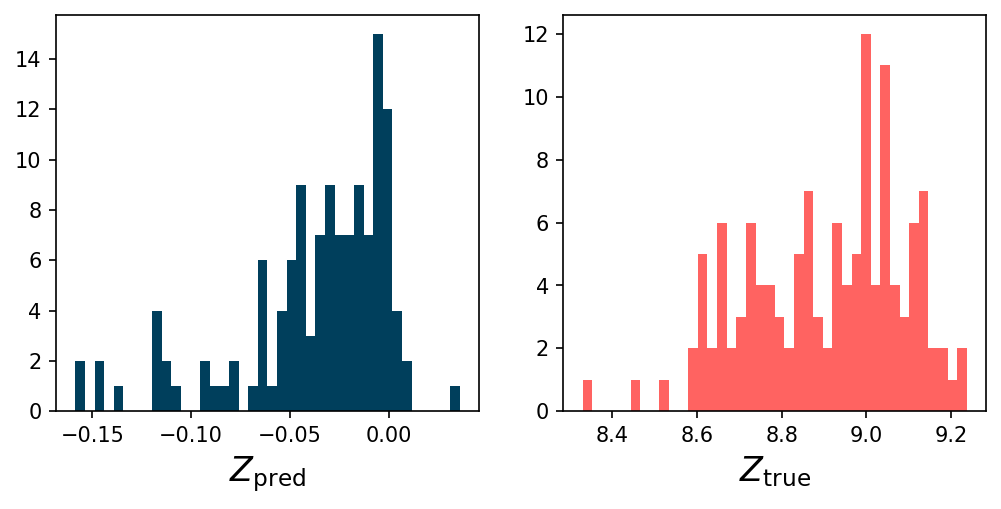

In [ ]:
# compare outputs with ground truths
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 3.5), dpi=150)

ax1.hist(predictions, bins=40, color='#003f5c')
ax1.set_xlabel('$Z_{\\rm pred}$', fontsize=16)

ax2.hist(labels, bins=40, color='#ff6361')
ax2.set_xlabel('$Z_{\\rm true}$', fontsize=16);

Note that these are very different! The typical prediction (before any CNN optimization) returns a value close to zero. This is unsurprising, as repeated matrix multplications will generally drive the outputs toward zero or infinity. Clever initialization of the neural network parameters can help us avoid divergence at first, but we will still need to optimize this network in order to get in the correct ballpark.

# Optimization

Great, we now know how to pass images forward through a model, and get some garbage-quality outputs.

But how do we make our model better? The whole point of machine learning is to let the model learn from examples, and eventually give you a better predictions!

Other resources:
- Overview of gradient optimization algorithms: https://ruder.io/optimizing-gradient-descent/
- Mathematical deep dive into backpropagating the loss function: https://brilliant.org/wiki/backpropagation/

## Loss function

In order to understand what it means for a model to do better, we first need to define what "better" means. In this case (regression on a single target), it's very easy. We've already talked about a loss function: the **root mean squared error (RMSE)**.

We want to minimize the RMSE as a function of the model parameters, given the data examples. Whenever we perform a minimization of a function $J$, given the data $x$, we simply need to find the values of model parameters $\theta$ that set its derivative to zero: $\nabla_\theta J(\theta; x) = 0$.

In practice, optimizing the loss function can be quite difficult. Neural networks are basically never convex functions, which means that you may not find a good solution (depending on your starting point). The loss function forms a high-dimensional surface, which I like to call a loss landscape -- this landscape might be riddled with saddle points and bad local minima, and so you need to find a way to iteratively update your model such that it gives better predictions.

If you want to see a glimpse of the kinds of topologies that these loss landscapes create, check out [this video](https://www.youtube.com/watch?v=As9rW6wtrYk) or the image below:
![](https://www.cs.umd.edu/~tomg/img/landscapes/noshort.png)


## Gradient descent

The gradient, $\nabla_\theta J(\theta; x)$, points in the direction (in our model parameter space) that corresponds to lower loss. That is, it tells us better values of our model parameters $\theta$ in order to improve predictions. This method is called **gradient descent**.

There's just a few problems. First, we'll be sampling different batches of data at a time, and the loss landscape actually depends on which batch of data $x$ we use! So the loss landscape is constantly shifting! (Note that this means we're actually doing *stochastic* gradient descent.) Second, computing the gradient only tells us the *local* direction of steepest descent, but it doesn't actually illustrate the entire loss landscape. If it's like descending down a mountain top, all we know is our current altitude (i.e. our loss), and the direction where we may want to go; we can take a step in that direction and then check our altitude after that step.

The smoothness of our loss landscape matters a lot here. If it's super bumpy, then the direction of steepest descent might vary wildly. This is a challenging problem for optmization. One of the ways to smooth the trajectory of our steps is by using an **adaptive** approach (see section on *Adam* below).



## Backpropagation of error

A third problem might not be immediately obvious: our model parameters actually depend *on each other*. If we want to update our model in the final fully connected layer of the neural network, then it also means that we'll have to tweak model parameters in the previous layer, which then connect to the model parameters in the layer before, and etc. Fortunately, this is computationally tractable and done automatically by `Pytorch`. Indeed, propagating the gradient is just called the *chain rule for derivatives*.

`Pytorch` provides everything we need for computing gradients throughout the model. Even making updates to the model is easy:

$$ \theta_{i+1} = \theta_i - \alpha \nabla_{\theta{_i}} J_i,$$

where $\alpha$ is the step size in the model parameter space, or **learning rate**, but we will discuss that in a section  below. $J$ is the RMSE loss function (in this case). Note that we use a negative sign, because we're trying to minimize the loss.

## Preventing overfitting and improving optimization

After a large number of updates, we might find that our gradient descent algorithm is able to approach the minimum of the loss surface. Remember that we don't necessarily the *global minimum* here: that is impossible because our surface constantly changes with different batches of data, and besides, we might start overfitting.

There are lots of ways, qualitatively, to prevent overfitting. One is to design a model that smooths over all the sharp edges in the model. For example, a popular CNN architecture is called the [ResNet architecture](https://arxiv.org/abs/1512.03385), and it introduces "skip connections" that make the loss landscape much nicer (and neural network optimization much, much better; Figure from [this paper](https://arxiv.org/abs/1712.09913)):
![](https://jithinjk.github.io/blog/images/loss_visualize/loss_1.png)

There are lots of other methods for preventing overfitting. One method called **Dropout** borrows from the idea of random forests: while any highly optimized model might be prone to overfit, a random ensemble of slightly less optimized models might be a lot better for generalization. It does this by randomly setting neurons in the final layers of the CNN to zero, which forces the network to learn redundant pathways for arriving at a good prediction.



## Data augmentation

One way to improve generalization in our image data set is to leverage symmetries. For example, horizontal and vertical flips, and rotations of 90, 180, and 270 degrees can improve the number of images by a factor of eight! (This is called the $D_4$ dihedral group, in case you care about group theory...)

There are other ways to "augment" our data set, for example, by also leveraging (approximate) translational invariance, but we don't do that here.

# The simple CNN model in action (forward + backward)

## Load data and model

In [ ]:
# re-initialize our simple model
model = SimpleNet()
model.to('cuda');

In [ ]:
# the oppposite of "eval" model is "train mode" -- let's ensure we're in 
# training mode, where Pytorch will keep track of gradients
model.train();

In [ ]:
# initialize the loss
train_loss = 0

In [ ]:
# get the first (or next) batch 
xb, yb = next(iter(dls.train))

xb.shape, yb.shape

(torch.Size([128, 3, 160, 160]), torch.Size([128]))

In [ ]:
# this should already be on the GPU
xb.device

device(type='cuda', index=0)

## The forward pass (again)

In [ ]:
# make a (very bad) prediction as before
prediction = model(xb)

prediction.shape

torch.Size([128, 1])

In [ ]:
# define our loss function
def RMSE(p, y): 
    """Square root of the flattened mean squared error loss"""
    return torch.sqrt(MSELossFlat()(p, y))

In [ ]:
# evaluate the loss 
loss = RMSE(prediction, yb)

loss

TensorBase(9.0317, device='cuda:0', grad_fn=<AliasBackward0>)

Remember how our true metallicities were centered around $Z_{\rm true} \approx 9$, while our initial predictions from the untrained CNN were close to 0? That's why the typical loss is 9, give or take.

In [ ]:
# keep track of the loss
train_loss += loss.item()

## The backward pass 

In [ ]:
# initialize our optimizer (we'll use stochastic gradient descent for now)
# - it needs to be passed the model parameters in order to update them
# - we will use a value of 0.01 for the learning rate, but we'll discuss this more later
optimizer = SGD(model.parameters(), lr=0.01)

In [ ]:
# remove any previous gradients
optimizer.zero_grad()

In [ ]:
# perform the backwards pass (and thus compute all gradients -- thanks Pytorch!)
# note that gradients are attached to the model parameters
loss.backward()

In [ ]:
# update model parameters
optimizer.step()

Yay! We've done a single update of our neural network! Usually we will keep passing training data through until we've fully completed a run through the entire training sample. Then, we will check how well we did on the validation set.

## Putting it all together: one epoch of training and validation

In [ ]:
# initialize model, optimizer, etc.
model = SimpleNet()
model.to('cuda')

optimizer = SGD(model.parameters(), lr=0.01)

# train
# =====
model.train()
train_loss = 0

# continue grabbing batches of training data
for xb, yb in iter(dls.train):   
    prediction = model(xb)
    loss = RMSE(prediction, yb)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# validate
# ========
valid_loss = 0

# no need to compute gradients, since we're not trying to update the model
# this let's us perform another forward pass after one epoch of training
with torch.no_grad():  
    model.eval()
    for xb, yb in iter(dls.valid):   
        prediction = model(xb)
        loss = RMSE(prediction, yb)
        valid_loss += loss.item()

# see how well we did
train_loss = train_loss / len(dls.train)
valid_loss = valid_loss / len(dls.valid)

print(f'Train: {train_loss:.4f}      Valid: {valid_loss:.4f}')



Train: 1.2011      Valid: 0.5995


## (*Practice*) Multiple epochs of training 

In [ ]:
# keep track
train_losses = [train_loss]
valid_losses = [valid_loss]

# iterate through more training (20 additional epochs)
for epoch in range(1, 21):

    model.train()
    train_loss = 0
    for xb, yb in iter(dls.train):   
        prediction =    ###### FILL THIS IN #####
        loss =          ###### FILL THIS IN #####
        train_loss += loss.item()
        
        ###### ALSO FILL IN ###### 
        # - reset gradients
        # - compute gradients using backward pass
        # - update model parameters (forward "step")

    valid_loss = 0
    with torch.no_grad():  
        model.eval()
        for xb, yb in iter(dls.valid):   
            prediction =   ###### FILL THIS IN #####
            loss =         ###### FILL THIS IN #####
            valid_loss += loss.item()

    # we typically normalize the loss by the number of batches
    train_loss = train_loss / len(dls.train)
    valid_loss = valid_loss / len(dls.valid)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch:2d}    Train: {train_loss:.4f}      Valid: {valid_loss:.4f}')


Epoch:  1    Train: 0.8134      Valid: 1.3256
Epoch:  2    Train: 0.7410      Valid: 0.5354
Epoch:  3    Train: 0.6873      Valid: 1.2023
Epoch:  4    Train: 0.6400      Valid: 0.4779
Epoch:  5    Train: 0.5969      Valid: 0.7446
Epoch:  6    Train: 0.5674      Valid: 0.3916
Epoch:  7    Train: 0.5258      Valid: 1.0034
Epoch:  8    Train: 0.5102      Valid: 0.4295
Epoch:  9    Train: 0.4846      Valid: 0.8690
Epoch: 10    Train: 0.4675      Valid: 0.3571
Epoch: 11    Train: 0.4469      Valid: 0.3860
Epoch: 12    Train: 0.4308      Valid: 0.5672
Epoch: 13    Train: 0.4166      Valid: 0.3218
Epoch: 14    Train: 0.4121      Valid: 0.4707
Epoch: 15    Train: 0.4008      Valid: 0.3864
Epoch: 16    Train: 0.3753      Valid: 0.3890
Epoch: 17    Train: 0.3641      Valid: 0.4033
Epoch: 18    Train: 0.3600      Valid: 0.3147
Epoch: 19    Train: 0.3403      Valid: 0.3394
Epoch: 20    Train: 0.3534      Valid: 0.3956


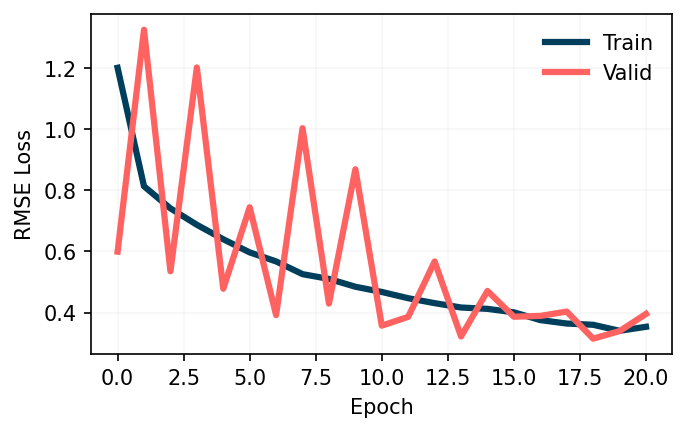

In [ ]:
plt.figure(figsize=(5, 3), dpi=150)
plt.plot(range(0, 21), train_losses, c='#003f5c', lw=3, label='Train')
plt.plot(range(0, 21), valid_losses, c='#ff6361', lw=3, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')

plt.legend(framealpha=0)
plt.grid(alpha=0.1)

Clearly, we see that our simple CNN implementation and training procedure isn't too great; 20 epochs of training only results in a RMSE loss of about 0.35, whereas we previously achieved < 0.10 RMSE loss in 10 epochs of training.

# Hyperparameters and expediting the optimization

## Learning rate

The learning rate is the most important hyperparameter for *efficiently* training a neural network. It determines how large each update is -- you can think of it as the coefficient to the gradient that is computed from the loss function. For example, a 1-dimension loss landscape $J(\theta)$ is shown below, while gradients multiplied by the learning rate are shown as red arrows:

![](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

We want to make sure that we select an optimal learning rate! There's a nice empirical method for doing this described by [Leslie Smith](https://arxiv.org/pdf/1506.01186.pdf) (and implemented in [Fastai](https://docs.fast.ai/callback.schedule.html#Learner.lr_find)).

## Weight decay

Regularization techniques mitigate overfitting by preventing the model from becoming overly dependent on just a few neurons in the network. Weight decay is a form of regularization related to (and sometimes misconstrued as) L2 regularization -- a method for penalizing extremely large neural network weights:

$$ J(\theta) = {\rm RMSE} + \frac{1}{2} \lambda ||\theta||^2,$$

where $\lambda$ is the weight decay coefficient and $\theta$ are the values of the network's weights.

Note that weight decay can sometimes clash with adaptive gradient descent methods (e.g., Adam, which is described below) and with batch normalization (introduced above). The respective solutions are to use [weight decay-decoupled Adam (AdamW)](](https://arxiv.org/abs/1711.05101)) and [to not use weight decay in any layer preceding batch normalization](](https://blog.janestreet.com/l2-regularization-and-batch-norm/)) (i.e., convolutional layers).



## Gradient descent with Momentum and adaptive momentum (Adam)

Stochastic gradient descent (SGD) is a nice straightforward method for maneuvering about the loss landscape and updating the neural network. A **momentum** term is commonly added: it simply keeps track of previous update directions, and includes a small contribution from those prior steps in the update rule:

$$ \mu_{i+1} = \beta \mu_i + \nabla J(\theta_i) $$
$$ \theta_{i+1} = \theta_i - \alpha \mu_{i+1}$$

If you take a look at many time steps, you'll find that the updates look like:

$$ \theta_{i+1} = \theta_{i} - \alpha \Big [ \nabla J(\theta_{i})  + \beta \nabla J(\theta_{i-i}) + \beta^2 \nabla J(\theta_{i-2}) + \beta^3 \nabla J(\theta_{i-3}) + \cdots \Big ]. $$

The second term looks like the Taylor expansion of an exponential function, and that's what it is sometimes referred to as an *exponentially decaying average* or *exponentially-weighted moving average* (EMA) of the gradient. If you set the hyperparameter $\beta$ to zero, we simply go back to gradient descent. A common choice for momentum is around $\beta = 0.99$.

A good way to gain intuition for how momentum works is by playing with [this awesome demo from distill.pub](https://distill.pub/2017/momentum/). The dynamics of adding momentum to gradient descent are like that of a ball rolling down a hill -- or loss landscape.

**Adam** makes it so that the dynamics are like that of a ball *with friction* rolling down a hill. It can also be described as a simply modification of gradient descent, e.g., [here](https://ruder.io/optimizing-gradient-descent/index.html#adam). Adam has been marketed as a "just plug it in and forget about it" optimizer since it should adapt well to a variety of optimization problems (and while people have found notable instances where it doesn't work as well as SGD, the [original Adam paper](https://arxiv.org/abs/1412.6980) has managed to rack up >70k citations...)

There are important caveats, e.g. [decoupling weight decay from the update step](https://arxiv.org/abs/1711.05101v3) which improves Adam significantly (sometimes this is called *AdamW*). This is incorporated in the Fastai `Adam()` implementation.

## Learning rate schedules

You may be wondering whether it makes sense to use a constant learning rate over the entire duration of training. Indeed, it doesn't make sense to take large steps towards the beginning of training when we're far away from a good model, and then continue taking large steps even as we're very close to an optimal region. Rather, we should decrease the learning rate over time, so as to make sure we are carefully descending into the local minima.

This is often implemented by changing the learning rate according to some schedule (often with a functional form). The default schedule is constant over time. Early practioners often used a method of decreasing the learning rate by a factor of 10 every 30 epochs of training (i.e., once convergence is achieved at a given learning rate) --  this allows the network to continue fitting. There are more sophisticated learning rate schedules, e.g.,: 
- a decreasing function in the shape of a cosine (sometimes called cosine annealing)
- a flat rate + cosine function
- a function that first increases (called the warm-up phase) and then decreases (the annealing phase)

Fastai implements the latter two methods, which have been shown to achieve ["super-convergence"](https://sgugger.github.io/the-1cycle-policy.html) -- extremely rapid convergence because of optimization at very high learning rates. These are implemented in the CNN `Learner` object as `fit_flat_cos()` and `fit_one_cycle()` functions.

## Improving the CNN model

We've already suggested that a CNN can benefit from batch normalization, skip connections, and a good choice of activation function. The original ResNet can be improved by adding [several small number of tweaks](https://arxiv.org/abs/1812.01187), and possibly by including other design choices. For example, the [Mish](https://arxiv.org/abs/1908.08681) or [SiLU](https://paperswithcode.com/method/silu) activation functions tend to produce more smooth loss landscapes than the oft-used ReLU (which is discontinuous in its first derivative). [Self-attention](https://arxiv.org/abs/1805.08318) can also be added after convolution layer activations to model *long-range* dependencies of morphological features.

# And that's it!

Now that we've covered everything, go back to the top and re-run the code. There are some specifics about the Fastai `DataBlock` and `DataLoaders` objects that can be read about in their documentation, or in a [blog post here](https://jwuphysics.github.io/blog/galaxies/astrophysics/deep%20learning/computer%20vision/fastai/2020/05/26/training-a-deep-cnn.html#Organizing-the-data-using-the-fastai-DataBlock-API).

# Bonus! Hello Universe DeepMerge classification example

See also the following resources...

- [Hello Universe tutorial](https://archive.stsci.edu/hello-universe/deepmerge) (written in TensorFlow/Keras)
- [MAST High Level Science Products](https://archive.stsci.edu/hlsp/deepmerge), which contain the nicely packaged data and documentation
- [Ćiprijanović et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26C....3200390C/abstract) (paper)

## Setting up the data set

In [ ]:
from astropy.io import fits
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
!wget -q --no-clobber https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-noisy.fits

In [ ]:
# organizing the data
with fits.open('hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-noisy.fits') as h:
    X_noisy = h[0].data
    y_noisy = h[1].data

X = tensor(np.asarray(X_noisy).astype('float32'))
y = tensor(np.asarray(y_noisy).astype('float32'))

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
# grabbing image statistics for normalization
image_means = X_train[:100].mean(dim=(0, 2, 3))
image_stds = X_train[:100].std(dim=(0, 2, 3))

transforms_train = Pipeline([ToTensor, Dihedral, Normalize.from_stats(image_means, image_stds)])
transforms_valid = Pipeline([ToTensor, Normalize.from_stats(image_means, image_stds)])

In [ ]:
# custom pytorch data set
class GalaxyDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target.type(torch.LongTensor) # <-- make sure you cast this...
        self.transform = transform
        
        # needed for fastai
        self.c = len(np.unique(target))
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
dset_train = GalaxyDataset(X_train, y_train, transform=transforms_train)
dset_valid = GalaxyDataset(X_valid, y_valid, transform=transforms_valid)

In [ ]:
def norm(vals, vmin=None, vmax=None, Q=8, stretch=None):
    """
    For visualization purposes normalize image with `arcsinh((vals-vmin)/(vmax-vmin)), 
    with vmin and vmax respectively defaulted to 0.01 and 0.99 quantiles of all values. 
    
    Q and stretch control the arcsinh softening parameter, see Lupton et al. 2004 and
    see https://docs.astropy.org/en/stable/_modules/astropy/visualization/lupton_rgb.html#make_lupton_rgb
    """
    vmin = vmin or np.quantile(vals, 0.02)
    vmax = vmax or np.quantile(vals, 0.98)
    
    if stretch is None:
        return np.arcsinh(Q*(vals - vmin) / (vmax-vmin)) / Q
    else:
        return np.arcsinh(Q*(vals - vmin) / stretch) / Q

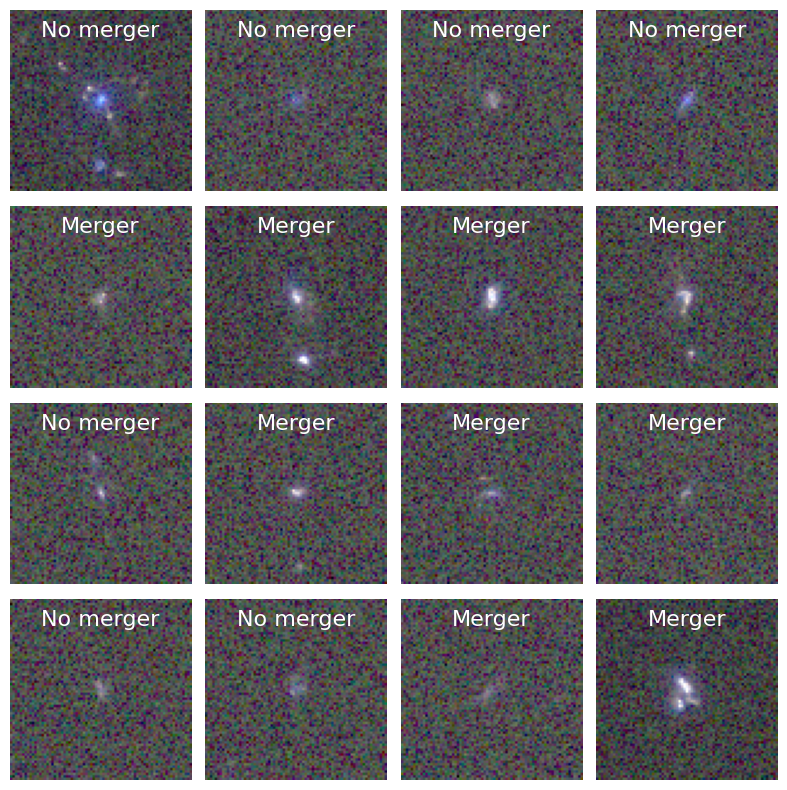

In [ ]:
fig = plt.figure(figsize=(8, 8), dpi=100) 

for i, (image, cls) in enumerate(zip(*dset_train[:16])):
    ax = fig.add_subplot(4, 4, i+1)
    
    image = norm(image, Q=5).permute(1, 2, 0).clip(0, 1)

    ax.imshow(image, aspect='equal')
    ax.text(0.5, 0.85, "Merger" if cls == 1 else "No merger", ha='center', color='white', fontsize=16, transform=ax.transAxes)
    
    ax.axis('off')

fig.tight_layout()

plt.show()

## (*Practice*) Setting up the neural network and train the classifier

In [ ]:
dls = ImageDataLoaders.from_dsets(dset_train, dset_valid, device='cuda', bs=128)

In [ ]:
# IMPLEMENT LEARNER AND TRAIN HERE

# note that you can include
#   metrics=[accuracy, Recall(), Precision()]
# in the Fastai Learner constructor in order to have it
# log the accuracy, recall (completeness), and precision (purity)

We can usually achieve >70% accuracy in 10 epochs or so on the noisy dataset.

## Next steps...

Check out additional improvements to CNNs. For example, self-attention (used to great effect in large language models; [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762)) can also be used in CNNs. Changing the activation function from ReLU to Leaky ReLU or a non-monotonic (e.g. GELU, Mish, etc) empirically seems to be useful. Adding deconvolution layers in place of batchnorm in the early portions of the network seems to improve performance ([Wu & Peek 2020](https://ui.adsabs.harvard.edu/abs/2020arXiv200912318W/abstract)). Some of these may provide the neural network architecture with inductive biases relevant to our astronomical data sets; feel free to explore more on these.